## 9.1 图像增广

图像增广（image augmentation）技术通过对训练图像做一系列随机改变，来产生相似但又不同的训练样本，从而扩大训练数据集的规模。图像增广的另一种解释是，随机改变训练样本可以降低模型对某些属性的依赖，从而提高模型的泛化能力。

In [1]:
%matplotlib inline
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from PIL import Image
import sys

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
%matplotlib inline
from mpl_toolkits import mplot3d # 三维画图
import numpy as np

import torch
import torchvision
from IPython import display
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b
        
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)
        
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
    
        
def load_data_fashion_mnist(batch_size):
    mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=True,  download=True, transform=transforms.ToTensor())
    mnist_test  = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
    num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter

def show_images(imgs, num_rows, num_cols, scale=2):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i][j].imshow(imgs[i * num_cols + j])
            axes[i][j].axes.get_xaxis().set_visible(False)
            axes[i][j].axes.get_yaxis().set_visible(False)
    return axes

def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n

def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

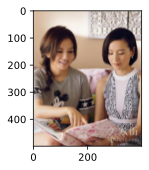

In [21]:
set_figsize()
img = Image.open('img/cat1.jpg')
plt.imshow(img)

In [22]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y, num_rows, num_cols, scale)

#### 9.1.1.1 翻转和裁剪

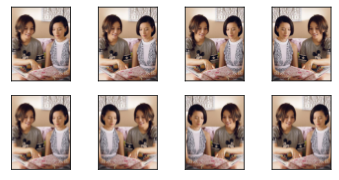

In [23]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

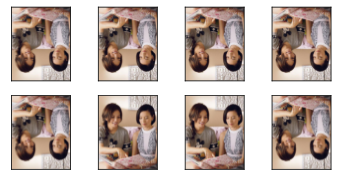

In [24]:
apply(img, torchvision.transforms.RandomVerticalFlip())

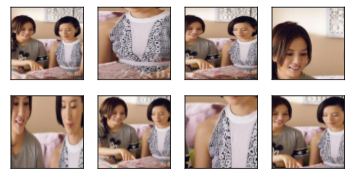

In [25]:
shape_aug = torchvision.transforms.RandomResizedCrop(200, scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

#### 9.1.1.2 变化颜色

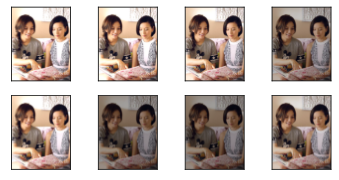

In [26]:
apply(img, torchvision.transforms.ColorJitter(brightness=0.5))

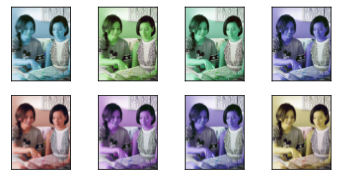

In [27]:
apply(img, torchvision.transforms.ColorJitter(hue=0.5))

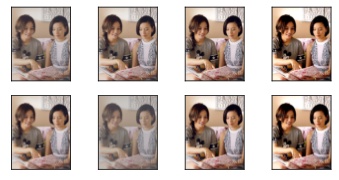

In [28]:
apply(img, torchvision.transforms.ColorJitter(contrast=0.5))

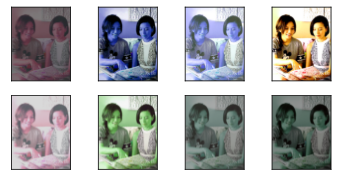

In [29]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

#### 9.1.1.3 叠加多个图像增广方法

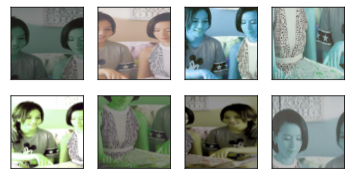

In [30]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img, augs)

### 9.1.2 使用图像增广训练模型

Files already downloaded and verified


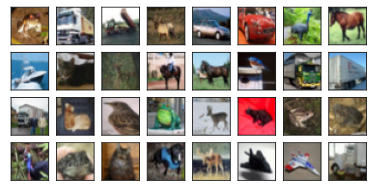

In [31]:
all_imges = torchvision.datasets.CIFAR10(train=True, root="./Datasets/CIFAR", download=True)
# all_imges的每一个元素都是(image, label)
show_images([all_imges[i][0] for i in range(32)], 4, 8, scale=0.8);

为了在预测时得到确定的结果，我们通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广

In [32]:
flip_aug = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

no_aug = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [33]:
num_workers = 0 if sys.platform.startswith('win32') else 4
def load_cifar10(is_train, augs, batch_size, root="./Datasets/CIFAR"):
    dataset = torchvision.datasets.CIFAR10(root=root, train=is_train, transform=augs, download=True)
    return DataLoader(dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers)

#### 9.1.2.1 使用图像增广训练模型

In [34]:
def train_with_data_aug(train_augs, test_augs, lr=0.001):
    batch_size, net = 256, torchvision.models.resnet18(10)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs=10)

In [35]:
train_with_data_aug(flip_aug, no_aug)

Files already downloaded and verified
Files already downloaded and verified
training on  cuda
epoch 1, loss 1.1674, train acc 0.649, test acc 0.749, time 71.6 sec
epoch 2, loss 0.2965, train acc 0.798, test acc 0.788, time 71.5 sec
epoch 3, loss 0.1601, train acc 0.836, test acc 0.784, time 71.4 sec
epoch 4, loss 0.1022, train acc 0.861, test acc 0.800, time 71.4 sec
epoch 5, loss 0.0714, train acc 0.879, test acc 0.819, time 71.5 sec
epoch 6, loss 0.0524, train acc 0.892, test acc 0.801, time 71.4 sec
epoch 7, loss 0.0400, train acc 0.904, test acc 0.793, time 71.4 sec
epoch 8, loss 0.0301, train acc 0.918, test acc 0.816, time 71.5 sec
epoch 9, loss 0.0242, train acc 0.926, test acc 0.812, time 71.5 sec
epoch 10, loss 0.0200, train acc 0.932, test acc 0.829, time 71.5 sec


### 小结

- 图像增广基于现有训练数据生成随机图像从而应对过拟合。
- 为了在预测时得到确定的结果，通常只将图像增广应用在训练样本上，而不在预测时使用含随机操作的图像增广。
- 可以从torchvision的transforms模块中获取有关图片增广的类。

## 9.2 微调

微调（fine tuning）由以下4步构成。

1. 在源数据集（如ImageNet数据集）上预训练一个神经网络模型，即源模型。
1. 创建一个新的神经网络模型，即目标模型。它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
1. 为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
1. 在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。

![jupyter](http://tangshusen.me/Dive-into-DL-PyTorch/img/chapter09/9.2_finetune.svg)

当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。

### 9.2.1 热狗识别

In [3]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import os


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 9.2.1.1 获取数据集

In [4]:
data_dir = './img'
os.listdir(os.path.join(data_dir, "hotdog")) # ['train', 'test']

['train', 'test']

In [5]:
train_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/train'))
test_imgs = ImageFolder(os.path.join(data_dir, 'hotdog/test'))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]],
      dtype=object)

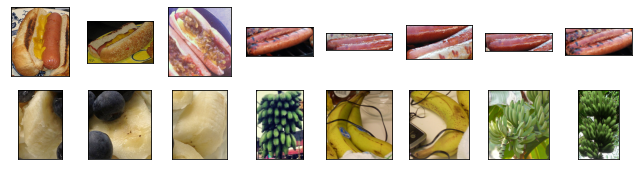

In [6]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4)

In [7]:
# 指定RGB三个通道的均值和方差来将图像通道归一化
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_augs = transforms.Compose([
        transforms.RandomResizedCrop(size=224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])

#### 9.2.1.2 定义和初始化模型

In [8]:
pretrained_net = models.resnet18(pretrained=True)

In [9]:
print(pretrained_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
pretrained_net.fc = nn.Linear(512, 2)
print(pretrained_net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
output_params = list(map(id, pretrained_net.fc.parameters()))
feature_params = filter(lambda p: id(p) not in output_params, pretrained_net.parameters())

lr = 0.01
optimizer = optim.SGD([{'params': feature_params},
                       {'params': pretrained_net.fc.parameters(), 'lr': lr * 10}],
                       lr=lr, weight_decay=0.001)

#### 9.2.1.3 微调模型

In [12]:
def train_fine_tuning(net, optimizer, batch_size=128, num_epochs=5):
    train_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/train'), transform=train_augs),
                            batch_size, shuffle=True)
    test_iter = DataLoader(ImageFolder(os.path.join(data_dir, 'hotdog/test'), transform=test_augs),
                           batch_size)
    loss = torch.nn.CrossEntropyLoss()
    train(train_iter, test_iter, net, loss, optimizer, device, num_epochs)

In [13]:
train_fine_tuning(pretrained_net, optimizer, 32)

training on  cuda
epoch 1, loss 1.6258, train acc 0.802, test acc 0.887, time 35.3 sec
epoch 2, loss 0.2506, train acc 0.881, test acc 0.904, time 35.0 sec
epoch 3, loss 0.0929, train acc 0.907, test acc 0.938, time 35.1 sec
epoch 4, loss 0.0564, train acc 0.925, test acc 0.936, time 35.1 sec
epoch 5, loss 0.0297, train acc 0.939, test acc 0.932, time 35.1 sec


In [16]:
scratch_net = models.resnet18(pretrained=False, num_classes=2)
lr = 0.1
optimizer = optim.SGD(scratch_net.parameters(), lr=lr, weight_decay=0.001)
train_fine_tuning(scratch_net, optimizer, 32)

training on  cuda
epoch 1, loss 1.4397, train acc 0.692, test acc 0.786, time 35.1 sec
epoch 2, loss 0.2367, train acc 0.793, test acc 0.799, time 35.0 sec
epoch 3, loss 0.1483, train acc 0.812, test acc 0.839, time 35.1 sec
epoch 4, loss 0.0995, train acc 0.826, test acc 0.849, time 35.1 sec
epoch 5, loss 0.0852, train acc 0.816, test acc 0.750, time 35.0 sec


### 小结

- 迁移学习将从源数据集学到的知识迁移到目标数据集上。微调是迁移学习的一种常用技术。
- 目标模型复制了源模型上除了输出层外的所有模型设计及其参数，并基于目标数据集微调这些参数。而目标模型的输出层需要从头训练。
- 一般来说，微调参数会使用较小的学习率，而从头训练输出层可以使用较大的学习率。

## 9.3 目标检测和边界框

图像里有多个我们感兴趣的目标，我们不仅想知道它们的类别，还想得到它们在图像中的具体位置。在计算机视觉里，我们将这类任务称为目标检测（object detection）或物体检测。

In [17]:
%matplotlib inline
from PIL import Image

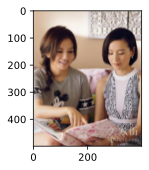

In [19]:
set_figsize()
img = Image.open('img/cat1.jpg')
plt.imshow(img);  # 加分号只显示图

### 9.3.1 边界框

In [21]:
# bbox是bounding box的缩写
dog_bbox, cat_bbox = [60, 45, 378, 516], [400, 112, 655, 493]

In [26]:
def bbox_to_rect(bbox, color):  # 本函数已保存在d2lzh_pytorch中方便以后使用
    # 将边界框(左上x, 左上y, 右下x, 右下y)格式转换成matplotlib格式：
    # ((左上x, 左上y), 宽, 高)
    return plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

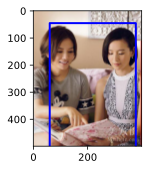

In [27]:
fig = plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

## 9.4 锚框

目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边缘从而更准确地预测目标的真实边界框（ground-truth bounding box）。不同的模型使用的区域采样方法可能不同。这里我们介绍其中的一种方法：它以每个像素为中心生成多个大小和宽高比（aspect ratio）不同的边界框。这些边界框被称为锚框（anchor box）

In [28]:
%matplotlib inline
from PIL import Image
import numpy as np
import math
import torch